In [ ]:
import os
import random
import time

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import imageio
import matplotlib.pyplot as plt


# FIXES
import tqdm
import multiprocessing as mp
mp.set_start_method('spawn', force=True)

# NOT RECOMMENDED FIX...
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
# These are the recommended hyperparameters
class Hyperparameters:
    env_id = "BreakoutNoFrameskip-v4"
    exp_name = "DQN_Breakout"
    seed = 1
    torch_deterministic = True
    capture_video = True
    save_model = True

    total_timesteps = 10_000_000
    learning_rate = 1e-4
    buffer_size = 1_000_000
    gamma = 0.995
    tau = 1
    target_network_frequency = 1000
    batch_size = 32
    start_e = 1
    end_e = 0.01
    exploration_fraction = 0.2
    learning_starts = 80_000
    train_frequency = 4


In [ ]:


# Imports all our hyperparameters from the other file
#from hyperparams import Hyperparameters as params
params = Hyperparameters

# stable_baselines3 have wrappers that simplifies
# the preprocessing a lot, read more about them here:
# https://stable-baselines3.readthedocs.io/en/master/common/atari_wrappers.html
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)
from stable_baselines3.common.buffers import ReplayBuffer


# Creates our gym environment and with all our wrappers.
def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            if idx == 0:
                env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

class QNetwork(nn.Module):
    def __init__(self, envs):
        super(QNetwork, self).__init__()
        self.network = nn.Sequential(
            # First convolutional layer with ReLU
            nn.Conv2d(4, 16, kernel_size=8, stride=4),
            nn.ReLU(),
            # Second convolutional layer with ReLU
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            # Flattening layer, using nn.Flatten to handle batch flattening
            nn.Flatten(),
            # Fully-connected layer with ReLU
            nn.Linear(32 * 9 * 9, 256),
            nn.ReLU(),
            # Output layer, no activation function here
            nn.Linear(256, envs.single_action_space.n)
        )

    def forward(self, x):
        # Normalize input by dividing by 255.0, as pixel values range from 0 to 255
        x = x / 255.0
        return self.network(x)


def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

losses = []
mean_losses = []
episode = 0.0


In [ ]:
if __name__ == "__main__":
    run_name = f"{params.env_id}__{params.exp_name}__{params.seed}__{int(time.time())}"

    random.seed(params.seed)
    np.random.seed(params.seed)
    torch.manual_seed(params.seed)
    torch.backends.cudnn.deterministic = params.torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # env setup
    envs = gym.vector.SyncVectorEnv([make_env(params.env_id, params.seed, 0, params.capture_video, run_name)])
    assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

    q_network = QNetwork(envs).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=params.learning_rate)
    target_network = QNetwork(envs).to(device)
    target_network.load_state_dict(q_network.state_dict())

    # We’ll be using experience replay memory for training our DQN.
    # It stores the transitions that the agent observes, allowing us to reuse this data later.
    # By sampling from it randomly, the transitions that build up a batch are decorrelated.
    # It has been shown that this greatly stabilizes and improves the DQN training procedure.
    rb = ReplayBuffer(
        params.buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        optimize_memory_usage=False,
        handle_timeout_termination=True,
    )

    loss = None
    obs = envs.reset()
    progress = tqdm.tqdm(range(params.total_timesteps))
    for global_step in progress:
        # Here we get epsilon for our epislon greedy.
        epsilon = linear_schedule(params.start_e, params.end_e, params.exploration_fraction * params.total_timesteps, global_step)

        if random.random() < epsilon:
            actions = envs.action_space.sample()
        else:
            q_values = q_network(torch.tensor(obs, dtype=torch.float32, device=device))
            actions = torch.argmax(q_values, dim=1).cpu().numpy()

        # Take a step in the environment
        next_obs, rewards, dones, infos = envs.step(actions)

        # Here we print our reward.
        if global_step % 500 == 0:
            for info in infos:
                if "episode" in info.keys():
                    episode = info['episode']['r']
                    break

            mean_loss = sum(losses)/len(losses) if losses else -1
            if mean_loss > 0:
                mean_losses.append((global_step, mean_loss))
            losses = []
            progress.set_description(f"global_step={global_step}, episodic_return={episode}, mean_loss={mean_loss:.7e}")

        # Save data to replay buffer
        real_next_obs = next_obs.copy()
        for idx, d in enumerate(dones):
            if d:
                real_next_obs[idx] = infos[idx]["terminal_observation"]

        # Here we store the transitions in D
        rb.add(obs, real_next_obs, actions, rewards, dones, infos)

        obs = next_obs
        # Training
        if global_step > params.learning_starts:
            if global_step % params.train_frequency == 0:
                # Sample random minibatch of transitions from D
                data = rb.sample(params.batch_size)
                # You can get data with:
                # data.observation, data.rewards, data.dones, data.actions

                with torch.no_grad():
                    # Now we calculate the y_j for non-terminal phi.
                    # Get the maximum Q-value for each next state
                    target_max, _ = target_network(data.next_observations).max(dim=1)
                    # Calculate y_j, taking into account whether the state is terminal
                    td_target = data.rewards.squeeze() + (1 - data.dones.squeeze()) * params.gamma * target_max

                old_val = q_network(data.observations).gather(1, data.actions).squeeze()
                loss = F.mse_loss(old_val, td_target) # The order is probably reversed but MSE does not care. 🤷🏻‍♂️
                losses.append(loss.item())

                # perform our gradient decent step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # update target network
            if global_step % params.target_network_frequency == 0:
                for target_network_param, q_network_param in zip(target_network.parameters(), q_network.parameters()):
                    target_network_param.data.copy_(
                        params.tau * q_network_param.data + (1.0 - params.tau) * target_network_param.data
                    )

    if params.save_model:
        model_path = f"{params.exp_name}_model"
        torch.save(q_network.state_dict(), model_path)
        print(f"model saved to {model_path}")

    envs.close()


/home/andreas/jupyter310/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:219: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 56.46GB > 17.79GB
  warnings.warn(
global_step=999500, episodic_return=3.0, mean_loss=6.2270952e-05: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [40:08<00:00, 415.23it/s]

model saved to DQN_Breakout_model


In [ ]:
# Fix things so we get an actual export of all the episodes

run_name = f"{params.env_id}__{params.exp_name}__{params.seed}__{int(time.time())}"

def episode_trigger(x):
    return True

# Creates our gym environment and with all our wrappers.
def make_env(env_id, seed, idx, capture_video, run_name):
    def thunk():
        env = gym.make(env_id)
        env = gym.wrappers.RecordEpisodeStatistics(env)
        if capture_video:
            if idx == 0:
                env = gym.wrappers.RecordVideo(env, f"videos/{run_name}", episode_trigger=episode_trigger)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)
        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)
        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env

    return thunk

# env setup
env = gym.vector.SyncVectorEnv([make_env(params.env_id, params.seed, 0, params.capture_video, run_name)])
assert isinstance(envs.single_action_space, gym.spaces.Discrete), "only discrete action space is supported"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

frames = []

model = QNetwork(env).to(device)
model.load_state_dict(torch.load(f"{params.exp_name}_model_10M"))
model.eval()

# Reset the environment
observation = env.reset(seed=42)
frames.append(np.transpose(observation.squeeze(0), (1, 2, 0)))

for _ in range(1000):
    with torch.no_grad():
        q_values = model(torch.tensor(observation, dtype=torch.float32, device=device))
        action = torch.argmax(q_values, dim=1)
    observation, reward, terminated, truncated = env.step(action)
    frames.append(np.transpose(observation.squeeze(0), (1, 2, 0)))

    if terminated or truncated:
        observation = env.reset()
        frames.append(np.transpose(observation.squeeze(0), (1, 2, 0)))

env.close()


# Save the frames as a video
imageio.mimsave('breakout_gameplay2.mp4', frames, fps=15)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (84, 84) to (96, 96) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


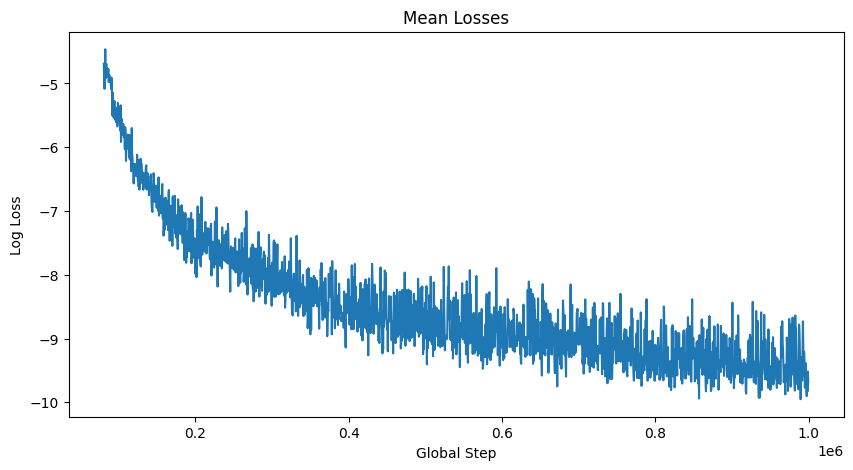

In [ ]:
import math
iterations, losses = zip(*mean_losses)
plt.figure(figsize=(10, 5))
plt.plot(iterations, [math.log(x) for x in losses])
plt.title('Mean Losses')
plt.xlabel('Global Step')
plt.ylabel('Log Loss')

plt.savefig('Mean_Losses_Plot.png')